# Лабораторная работа. Прогнозирование временных рядов для несезонных и сезонных процессов.

## 1. Прогнозирование рядов без сезонности, построение моделей ARIMA

In [2]:
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.tsa.api as smt
import statsmodels.stats as sm_stat
import statsmodels.tsa.statespace as sm_sp
import operator
import pandas as pd
import numpy as np
import ml_metrics as metrics
import warnings
warnings.filterwarnings('ignore')

### Загрузим данные

In [3]:
def load_data(filename):
    lst = []
    with open(filename, 'r') as f:
        for line in f:
            lst.append(float(line))
    return lst

dataset_full = load_data('ser1.txt')
dataset = dataset_full[:-3]

### Построим временной ряд

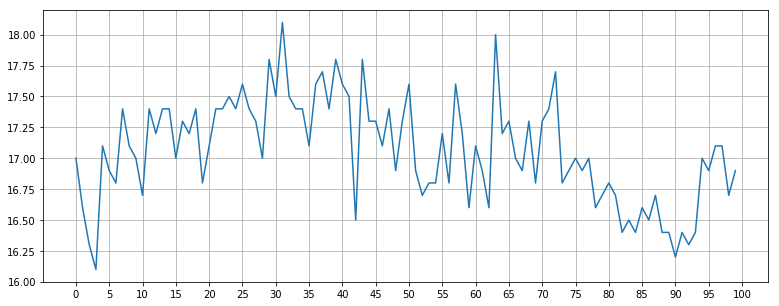

In [32]:
def show_graph(y, x_ticks):
    plt.figure(figsize=(13,5))
    plt.plot(y)
    plt.grid()
    plt.xticks(np.arange(0, len(y)+1, x_ticks))
    plt.show()

show_graph(dataset, 5)

### АКФ и ЧАКФ (1/4 длины выборки)

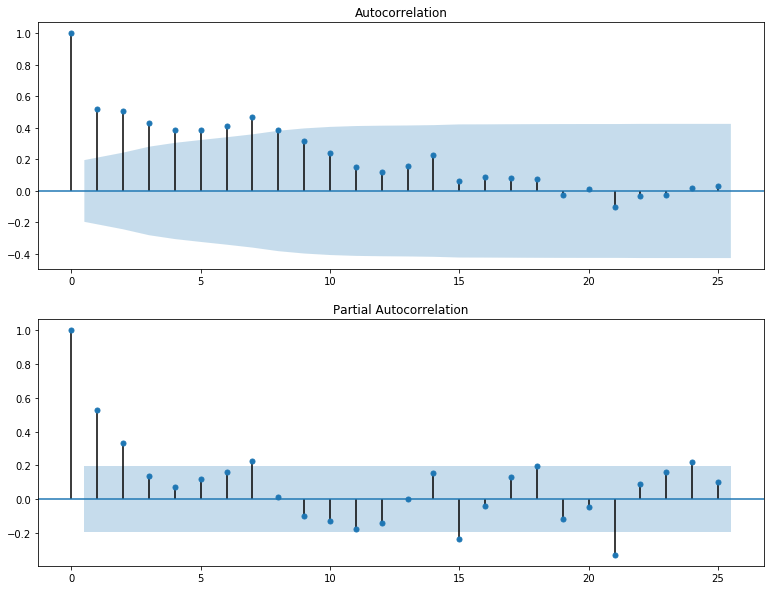

In [33]:
def plot_Acorr_PAcorr(dataset, Acorr_lags, PAcorr_lags):
    fig = plt.figure(figsize=(13, 10))
    ax1 = fig.add_subplot(211)
    fig = sm.graphics.tsa.plot_acf(dataset, lags=Acorr_lags, ax=ax1)
    ax2 = fig.add_subplot(212)
    fig = sm.graphics.tsa.plot_pacf(dataset, lags=PAcorr_lags, ax=ax2)
    plt.show()

plot_Acorr_PAcorr(dataset, 25, 25)

### Значимые лаги
Для АКФ: 7 (первые 7, не включая нулевой)
<br>
Для ЧАКФ: 3 (1, 2 и 7)

### Построение модели временного ряда
```Для моделирования будем использовать модель ARIMA. Нам нужно знать ее порядок, состоящий из 2-х параметров:
    p — порядок компоненты AR (в моём случае максимум 3)
    d — порядок интегрированного ряда (в моём случае d = 0)
    q — порядок компонетны MA (в моём случае максимум 7)```

#### Теперь рассмотрим все варианты моделей и проверим их с помощью критериев Акаике и Шварца

In [34]:
class ModelParams:
    def __init__(self, p=0, d=0, q=0, P=0, Q=0, D=0, s=0, tvalues=0, pvalues=0, AIC=0, BIC=0, trend=None):
        self.p = p
        self.d = d
        self.q = q
        self.P = P
        self.D = D
        self.Q = Q
        self.s = s
        self.tvalues = tvalues
        self.pvalues = pvalues
        self.AIC = AIC
        self.BIC = BIC
        self.trend = trend
        self.sum_metric = (AIC + BIC) / 2

model_params = []

for p in range(3+1):
    for q in range(7+1):
        for trend in ('n', 'c', 't', 'ct'):
            try:
                model = sm.tsa.ARIMA(dataset, 
                                     order=(p, 0, q)).fit(full_output=True, disp=0, trend=trend)
            except:
                continue

            mp = ModelParams(p=p, q=q, tvalues=model.tvalues, 
                             pvalues=model.pvalues, AIC=model.aic, BIC=model.bic, trend=trend)
            model_params.append(mp)

#### Отсортируем модели по суммарной метрике среднего AIC и BIC, выберем модели без незначимых коэффициентов

In [35]:
sorted_model_params = sorted(model_params, key=operator.attrgetter('sum_metric'))

fit_models = []

for m in sorted_model_params:
    if max(m.pvalues) > 0.05: 
        continue # Если да, то модель имеет незначимые коэффициенты
        
    fit_models.append(m)
    
print("Количество скомпилированных моделей: {} \n"
      "Из них моделей только со значимыми членами: {} \n".format(len(sorted_model_params), 
                                                              len(fit_models)))

Количество скомпилированных моделей: 18 
Из них моделей только со значимыми членами: 8 



### Проверим остатки на отсутствие автокорреляции (тест Льюнга-Бокса)

In [36]:
models = {}

for m in fit_models:
    model = sm.tsa.ARIMA(dataset, order=(m.p, 0, m.q)).fit(full_output=True, disp=0)
    models[f"ARIMA({m.p},0,{m.q})"] = model
    test_results = sm_stat.diagnostic.acorr_ljungbox(model.resid, lags=[10])
    print(f"Результат теста: {round(test_results[0][0], 8)} pvalue: {test_results[1][0]}")

Результат теста: 9.15958133 pvalue: 0.5170287620216178
Результат теста: 10.53368117 pvalue: 0.39498201320999365
Результат теста: 8.704332 pvalue: 0.5603745513620709
Результат теста: 22.61542296 pvalue: 0.012258672238814945
Результат теста: 24.45266733 pvalue: 0.006485383494842737
Результат теста: 43.66058983 pvalue: 3.787318019411588e-06
Результат теста: 77.94684797 pvalue: 1.2665274585539302e-12
Результат теста: 183.19266383 pvalue: 5.089681540610976e-34


### Значение показателя p-value велико, остатки некоррелированные. Любая из моделей пригодна для описания процесса

In [37]:
models

{'ARIMA(1,0,1)': <statsmodels.tsa.arima_model.ARMAResultsWrapper at 0x21f9a1677b8>,
 'ARIMA(2,0,0)': <statsmodels.tsa.arima_model.ARMAResultsWrapper at 0x21f9a167ef0>,
 'ARIMA(3,0,3)': <statsmodels.tsa.arima_model.ARMAResultsWrapper at 0x21f9a554e48>,
 'ARIMA(1,0,0)': <statsmodels.tsa.arima_model.ARMAResultsWrapper at 0x21f9a5547f0>,
 'ARIMA(0,0,3)': <statsmodels.tsa.arima_model.ARMAResultsWrapper at 0x21f9a1dca90>,
 'ARIMA(0,0,2)': <statsmodels.tsa.arima_model.ARMAResultsWrapper at 0x21f9a14f9e8>,
 'ARIMA(0,0,1)': <statsmodels.tsa.arima_model.ARMAResultsWrapper at 0x21f9a14f5f8>,
 'ARIMA(0,0,0)': <statsmodels.tsa.arima_model.ARMAResultsWrapper at 0x21f9a14fcc0>}

### Построим для выбранных моделей прогнозы на один, два, три шага вперед

In [38]:
train_src_len = len(dataset)
print("Модель | Знач[-3] | △Знач | Знач[-2] | △Знач | Знач[-1] | △Знач | Сумма △знач | σ на 3 отсчета")
print("------------------------------------------------------------------------------------------------")
print("Эталон       | {:.4f} | {:.4f} | {:.4f} | {:.4f} | {:.4f} | {:.4f} | {:2.4f} | {:.4f}".format(
    round(dataset_full[-3], 4), 0,
    round(dataset_full[-2], 4), 0,
    round(dataset_full[-1], 4), 0, 0, 0))

predicts_by_model = {}

for modelname, model in models.items():
    predict = model.predict(train_src_len, train_src_len + 2)
    predicts_by_model[modelname] = list(predict[-3:])
    predicts_list = list(predict[-3:])
    print("{} | {:.4f} | {:.4f} | {:.4f} | {:.4f} | {:.4f} | {:.4f} | {:2.4f} | {:.4f}".format(
        modelname,
        round(predicts_list[-3], 4), 
        round(abs(predicts_list[-3] - dataset_full[-3]), 4),
        round(predicts_list[-2], 4), 
        round(abs(predicts_list[-2] - dataset_full[-2]), 4),
        round(predicts_list[-1], 4), 
        round(abs(predicts_list[-1] - dataset_full[-1]), 4),
        round(sum([abs(predicts_list[i] - dataset_full[i]) for i in range(-3, 0)]), 4),
        metrics.rmse(dataset_full[-3:], [val for val in predicts_list[-3:]])
    ))

Модель | Знач[-3] | △Знач | Знач[-2] | △Знач | Знач[-1] | △Знач | Сумма △знач | σ на 3 отсчета
------------------------------------------------------------------------------------------------
Эталон       | 16.5000 | 0.0000 | 17.2000 | 0.0000 | 16.4000 | 0.0000 | 0.0000 | 0.0000
ARIMA(1,0,1) | 16.8838 | 0.3838 | 16.8905 | 0.3095 | 16.8969 | 0.4969 | 1.1901 | 0.4041
ARIMA(2,0,0) | 16.8840 | 0.3840 | 16.9436 | 0.2564 | 16.9590 | 0.5590 | 1.1994 | 0.4186
ARIMA(3,0,3) | 16.8779 | 0.3779 | 16.8554 | 0.3446 | 16.8811 | 0.4811 | 1.2035 | 0.4054
ARIMA(1,0,0) | 16.9772 | 0.4772 | 17.0171 | 0.1829 | 17.0377 | 0.6377 | 1.2978 | 0.4718
ARIMA(0,0,3) | 16.9131 | 0.4131 | 16.9511 | 0.2489 | 17.0609 | 0.6609 | 1.3229 | 0.4723
ARIMA(0,0,2) | 16.9284 | 0.4284 | 17.0454 | 0.1546 | 17.0610 | 0.6610 | 1.2440 | 0.4635
ARIMA(0,0,1) | 17.0488 | 0.5488 | 17.0620 | 0.1380 | 17.0620 | 0.6620 | 1.3488 | 0.5028
ARIMA(0,0,0) | 17.0620 | 0.5620 | 17.0620 | 0.1380 | 17.0620 | 0.6620 | 1.3620 | 0.5077


### Модель ARIMA(1,0,1) является лучшей по показателю СКО

## 2. Прогнозирование рядов с сезонностью, построение моделей SARIMA

In [39]:
season_dataset_full = load_data("tokr.txt")

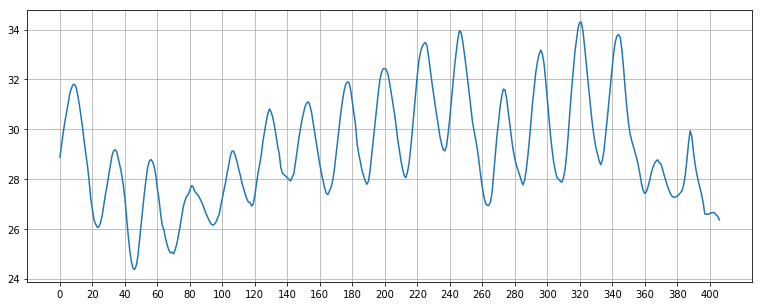


Количество значений: 407


In [40]:
show_graph(season_dataset_full, 20)
data_len = len(season_dataset_full)
print("\nКоличество значений:", data_len)

### АКФ и ЧАКФ (1/4 длины выборки)

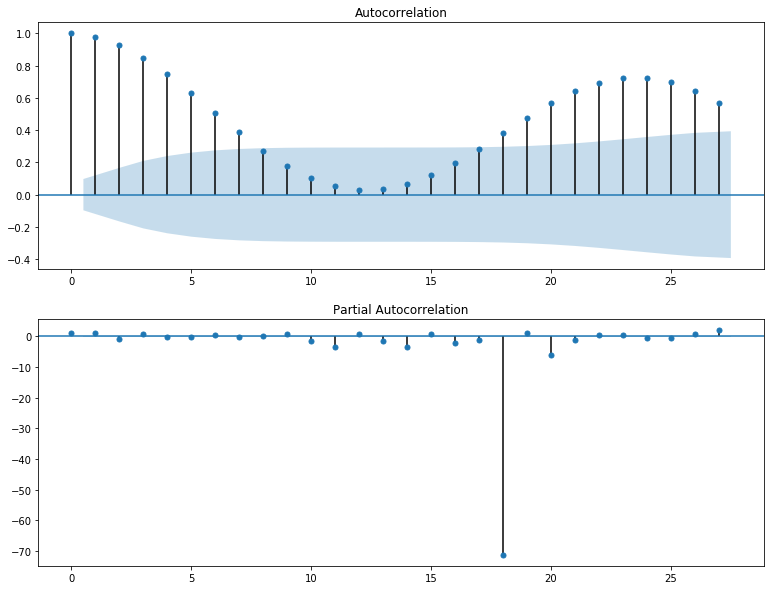

In [41]:
plot_Acorr_PAcorr(season_dataset_full, data_len // 15, data_len // 15)

### Порядок сезонности - 24
#### Разделим исходные данные на обучающую выборку и тестовую учитывая порядок сезонности

In [42]:
s_coef = 24
new_data_len = (data_len // s_coef) * s_coef
season_dataset = season_dataset_full[:new_data_len]

print(f"Длина обучающей выборки: {new_data_len}\nДлина тестовой выборки: {data_len - new_data_len}")

Длина обучающей выборки: 384
Длина тестовой выборки: 23


### Выполним операцию сезонного дифференцирования

In [43]:
data = pd.Series(season_dataset)
data = data.diff(s_coef).dropna()

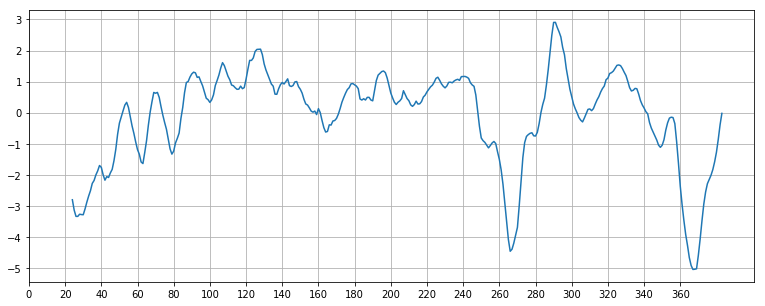

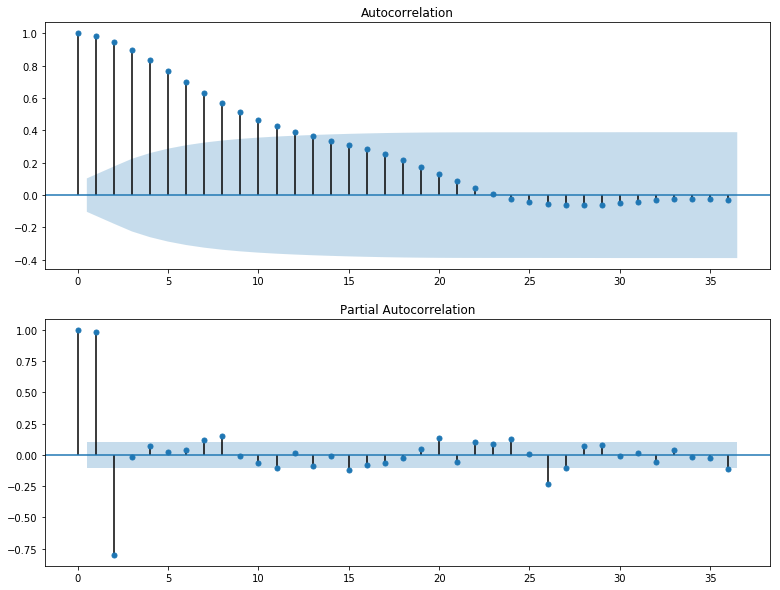

In [44]:
show_graph(data, 20)
plot_Acorr_PAcorr(data, len(data) // 10, len(data) // 10)

In [45]:
s_params = {
    'p': 2,
    'd': 0,
    'q': 10,
    'P': 0,
    'D': 1,
    'Q': 0,
    's': 24
}


season_models_chars = []

for p in range(s_params['p'], -1, -1):
    for q in range(s_params['q'], -1, -1):
        for P in range(s_params['P'], -1, -1):
            for Q in range(s_params['Q'], -1, -1):
                try:
                    model = sm.tsa.statespace.SARIMAX(data,
                                    order=(p, s_params['d'], q),
                                    seasonal_order=(P, s_params['D'], Q, s_params['s'])
                                   ).fit(full_output=True, disp=0)
                
                    mp = ModelParams(p=p, d=s_params['d'],
                                     q=q, P=P, D=s_params['D'], Q=Q, s=s_params['s'],
                                     tvalues=model.tvalues, pvalues=model.pvalues,
                                     AIC=model.aic, BIC=model.bic)
                    season_models_chars.append(mp)
                except: # Если процесс не стационарен
                    continue
                    
season_models_chars.pop()

In [46]:
season_models = []

for m in season_models_chars:
    if max(m.pvalues[:-1]) > 0.05: 
        continue # Если да, то модель имеет незначимые коэффициенты
    season_models.append(m)

print("Количество скомпилированных моделей: {} \n"
      "Из них модели только со значимыми членами: {} \n".format(len(season_models_chars), 
                                                              len(season_models)))

Количество скомпилированных моделей: 32 
Из них модели только со значимыми членами: 22 



In [48]:
sorted_all_models = sorted(season_models_chars, key=operator.attrgetter('sum_metric'))
sorted_models = sorted(season_models, key=operator.attrgetter('sum_metric'))

print("Лучшие 3 модели только со значимыми коэффициентами: \n")
for m in sorted_models[:3]:
    print("SARIMA ({},{},{})({},{},{},{})\n pvalues: {} \nAIC: {} BIC: {} Sum_metric: {}\n".format(m.p, m.d, m.q, m.P, m.D, m.Q, m.s, m.pvalues, m.AIC, m.BIC, m.sum_metric))

print("\n\nЛучшая модель среди всех исходя из метрики sm=((AIC+BIC)/2)(включая модели с незначимыми коэффициентами): \n")

for m in sorted_all_models[:1]:
    print("\nSARIMA ({},{},{})({},{},{},{})\n pvalues: {} \nAIC: {} BIC: {} Sum_metric: {}\n".format(m.p, m.d, m.q, m.P, m.D, m.Q, m.s, m.pvalues, m.AIC, m.BIC, m.sum_metric))

Лучшие 3 модели только со значимыми коэффициентами: 

SARIMA (1,0,8)(0,1,0,24)
 pvalues: ar.L1     1.533454e-106
ma.L1      6.084413e-78
ma.L2      1.171871e-42
ma.L3      1.515063e-51
ma.L4      1.332831e-42
ma.L5      1.142054e-31
ma.L6      3.237669e-25
ma.L7      4.242212e-22
ma.L8      8.881147e-12
sigma2     1.419347e-30
dtype: float64 
AIC: -142.46785176145147 BIC: -104.29674016181943 Sum_metric: -123.38229596163545

SARIMA (2,0,8)(0,1,0,24)
 pvalues: ar.L1      2.317968e-03
ar.L2      5.546953e-09
ma.L1     7.161257e-118
ma.L2      2.880753e-88
ma.L3      2.948468e-86
ma.L4      3.305580e-76
ma.L5      2.323688e-69
ma.L6      2.676167e-78
ma.L7      1.333560e-60
ma.L8      6.553726e-36
sigma2     2.709990e-34
dtype: float64 
AIC: -141.3969224682195 BIC: -99.40869970862424 Sum_metric: -120.40281108842186

SARIMA (2,0,1)(0,1,0,24)
 pvalues: ar.L1      0.000000e+00
ar.L2     1.355298e-120
ma.L1      1.303394e-03
sigma2     9.869825e-51
dtype: float64 
AIC: -117.21418143936512 BIC:

### SARIMA (1,0,8)(0,1,0,24) - лучшая модель по Метрике (AIC+BIC)/2, не имеющая незначительных коэффициентов
### Проведем тест Льюнга-Бокса

In [49]:
s_models = {}

for m in sorted_models[:3]:
    model = sm.tsa.statespace.SARIMAX(season_dataset,
                                      order=(m.p, m.d, m.q),seasonal_order=(m.P, m.D, m.Q, m.s)
                                     ).fit(full_output=True, disp=0)

    s_models["SARIMA({},{},{})x({},{},{},{})".format(m.p, m.d, m.q, m.P, m.D, m.Q, m.s)] = model

    al_test_res = sm_stat.diagnostic.acorr_ljungbox(model.resid)

    print("Model: SARIMA({},{},{})x({},{},{},{}) AIC:{:.2f}\n "
          "The Ljung-Box test statistic: {} pvalue: {}\n".format(m.p, 
                                                               m.d, m.q, m.P, m.D, m.Q, m.s, 
                                                               m.AIC, al_test_res[0][0], 
                                                               al_test_res[1][0]))

Model: SARIMA(1,0,8)x(0,1,0,24) AIC:-142.47
 The Ljung-Box test statistic: 356.495824991888 pvalue: 1.631617013628765e-79

Model: SARIMA(2,0,8)x(0,1,0,24) AIC:-141.40
 The Ljung-Box test statistic: 356.49792806233876 pvalue: 1.6298974316026596e-79

Model: SARIMA(2,0,1)x(0,1,0,24) AIC:-117.21
 The Ljung-Box test statistic: 356.4906466818368 pvalue: 1.635858811904494e-79



In [50]:
training_data_len = len(season_dataset)
testing_data_len = len(season_dataset_full) - len(season_dataset) + 1
predicts_by_s_model = {}

for modelname, model in s_models.items():
    predict = model.predict(training_data_len, training_data_len + testing_data_len - 1)
    predicts_by_s_model[modelname] = list(predict[-testing_data_len:])

### Построим прогнозы

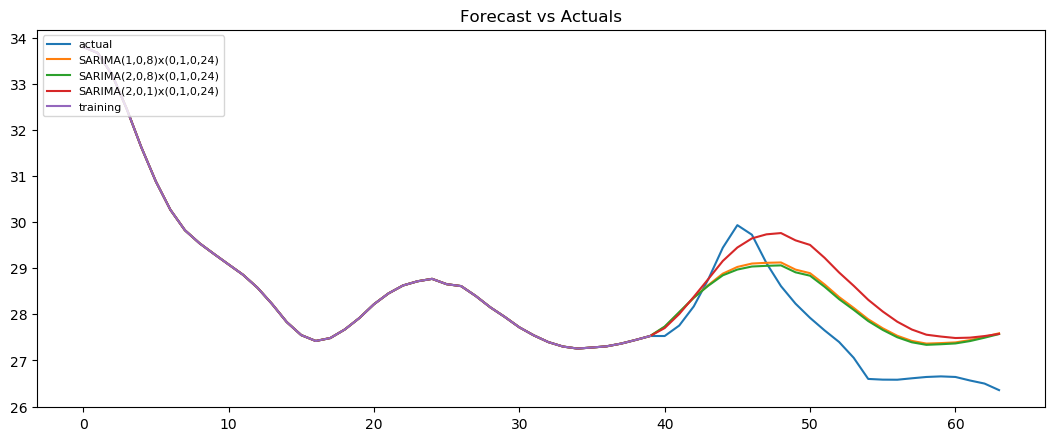

In [51]:
plt.figure(figsize=(13,5), dpi=100)
plt.plot(season_dataset[-40:] + season_dataset_full[-testing_data_len:], label='actual')

for model, array_values in predicts_by_s_model.items():
    plt.plot(season_dataset[-40:] + array_values, label=model)

plt.plot(season_dataset[-40:], label='training')
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

## Лучшей моделью является SARIMA(1,0,8)x(0,1,0,24)

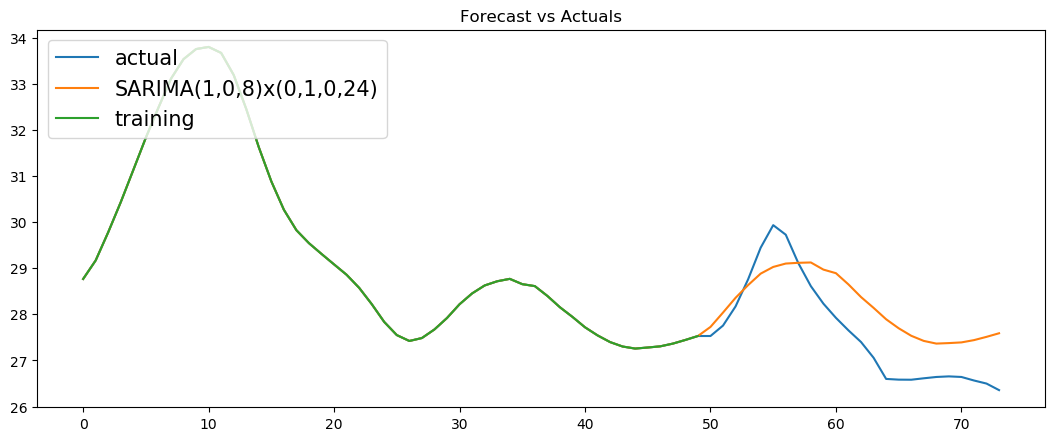

In [52]:
plt.figure(figsize=(13,5), dpi=100)
plt.plot(season_dataset[-50:] + season_dataset_full[-testing_data_len:], label='actual')
plt.plot(season_dataset[-50:] + predicts_by_s_model['SARIMA(1,0,8)x(0,1,0,24)'], 
         label='SARIMA(1,0,8)x(0,1,0,24)')
plt.plot(season_dataset[-50:], label='training')
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=15)
plt.show()